Processing timestep 12...
Processing timestep 13...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/3365801651.py:82: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)


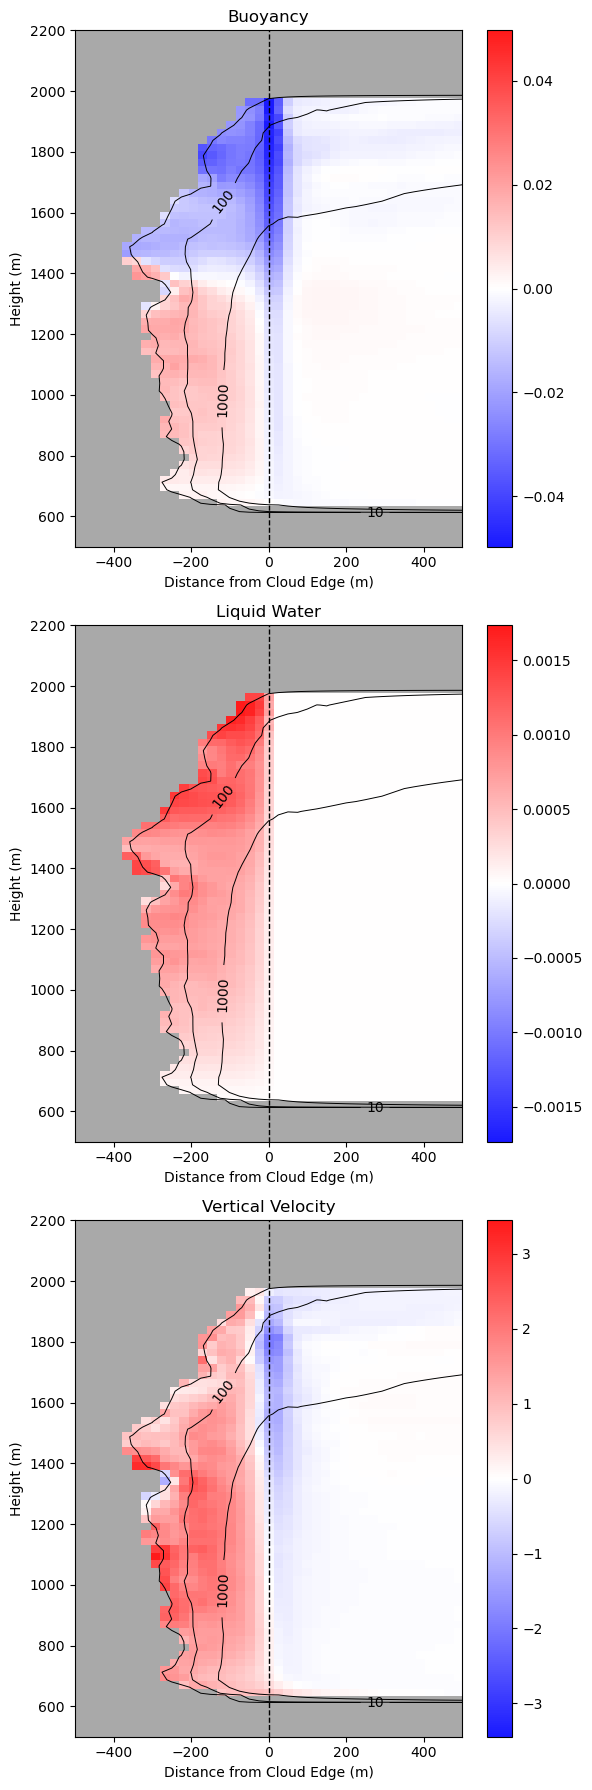

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt, binary_erosion
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.colors import TwoSlopeNorm

# Constants
horizontal_resolution = 25  # Horizontal resolution in meters

# File paths and variable names
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
files = {
    'w': data_dir + 'rico.w.nc',
    'l': data_dir + 'rico.l.nc',
    'b': data_dir + 'rico.buoyancy.nc',  # Buoyancy file
    't': data_dir + 'rico.t.nc'          # Temperature file (contains 'zt')
}
var_names = {
    'w': 'w',
    'l': 'l',
    'b': 'buoyancy',
    't': 't'
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep].astype(np.float64)
        return data  # Units are assumed to be correct

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_values_vs_distance(buoyancy_data, liquid_water_data, w_data, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge."""
    height_levels, ny, nx = buoyancy_data.shape
    total_distance = 2 * max_distance + 1
    results = {var: np.full((height_levels, total_distance), np.nan) for var in ['buoyancy', 'liquid_water', 'w']}
    results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

    for z in range(height_levels):
        mask = cloud_mask[z]
        if mask.any():
            dist_out = distance_transform_cdt(~mask, metric='taxicab')
            dist_in = distance_transform_cdt(mask, metric='taxicab')
            distances = np.where(mask, -dist_in + 1, dist_out)

            # Identify cloud edges and set distance to 0
            eroded_mask = binary_erosion(mask)
            cloud_edge = mask & ~eroded_mask
            distances[cloud_edge] = 0

            for d in range(-max_distance, max_distance + 1):
                idx = np.where(distances == d)
                if idx[0].size > 0:
                    pos = d + max_distance
                    results['buoyancy'][z, pos] = np.mean(buoyancy_data[z, idx[0], idx[1]])
                    results['liquid_water'][z, pos] = np.mean(liquid_water_data[z, idx[0], idx[1]])
                    results['w'][z, pos] = np.mean(w_data[z, idx[0], idx[1]])
                    results['cloud_count'][z, pos] += idx[0].size
    return results

def process_timesteps(timesteps, max_distance):
    all_results = []
    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        b_data = load_data(files['b'], var_names['b'], timestep)
        l_data = load_data(files['l'], var_names['l'], timestep)
        w_data = load_data(files['w'], var_names['w'], timestep)

        cloud_mask = l_data > 1e-5  # Threshold for cloud presence
        results = calculate_values_vs_distance(b_data, l_data, w_data, cloud_mask, max_distance)
        all_results.append(results)

    mean_results = {}
    for key in all_results[0]:
        stacked_data = np.array([res[key] for res in all_results])
        if key == 'cloud_count':
            mean_results[key] = np.sum(stacked_data, axis=0)
        else:
            mean_results[key] = np.nanmean(stacked_data, axis=0)
    return mean_results

# Parameters
timesteps = list(range(12, 14))
max_distance_meters = 500
max_distance = max_distance_meters // horizontal_resolution
distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Process data
mean_results = process_timesteps(timesteps, max_distance)
zt_values = load_zt(files['t'])  # Load 'zt' from the temperature file

# Plotting
variables = ['buoyancy', 'liquid_water', 'w']
titles = ['Buoyancy', 'Liquid Water', 'Vertical Velocity']


fig, axs = plt.subplots(3, 1, figsize=(6, 18))

for ax, var, title in zip(axs, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])

    # Colormap settings
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.linspace(0, 1, cmap.N))
    cmap[:, -1] = 0.9  # Transparency
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Normalize using TwoSlopeNorm to center at 0
    vmin_data = np.nanmin(data)
    vmax_data = np.nanmax(data)
    vmax_abs = max(abs(vmin_data), abs(vmax_data))
    norm = TwoSlopeNorm(vcenter=0, vmin=-vmax_abs, vmax=vmax_abs)

    # Plot
    im = ax.imshow(
        data,
        cmap=cmap,
        norm=norm,
        origin='lower',
        aspect='auto',
        extent=[distance_meters[0], distance_meters[-1], zt_values[0], zt_values[-1]]
    )
    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (m)')
    ax.set_ylabel('Height (m)')
    ax.set_ylim(500, 2200)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    fig.colorbar(im, ax=ax)

    # Contours
    cloud_count = mean_results['cloud_count']
    levels = [10, 100, 1000]
    cs = ax.contour(
        distance_meters,
        zt_values,
        cloud_count,
        levels=levels,
        colors='black',
        linewidths=0.7
    )
    ax.clabel(cs, fmt='%d')

plt.tight_layout()
plt.show()

# Difference to the domain mean

Processing timestep 3...
Processing timestep 4...
Processing timestep 5...
Processing timestep 6...
Processing timestep 7...
Processing timestep 8...
Processing timestep 9...
Processing timestep 10...
Processing timestep 11...
Processing timestep 12...
Processing timestep 13...
Processing timestep 14...
Processing timestep 15...
Processing timestep 16...
Processing timestep 17...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/3291663245.py:104: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)


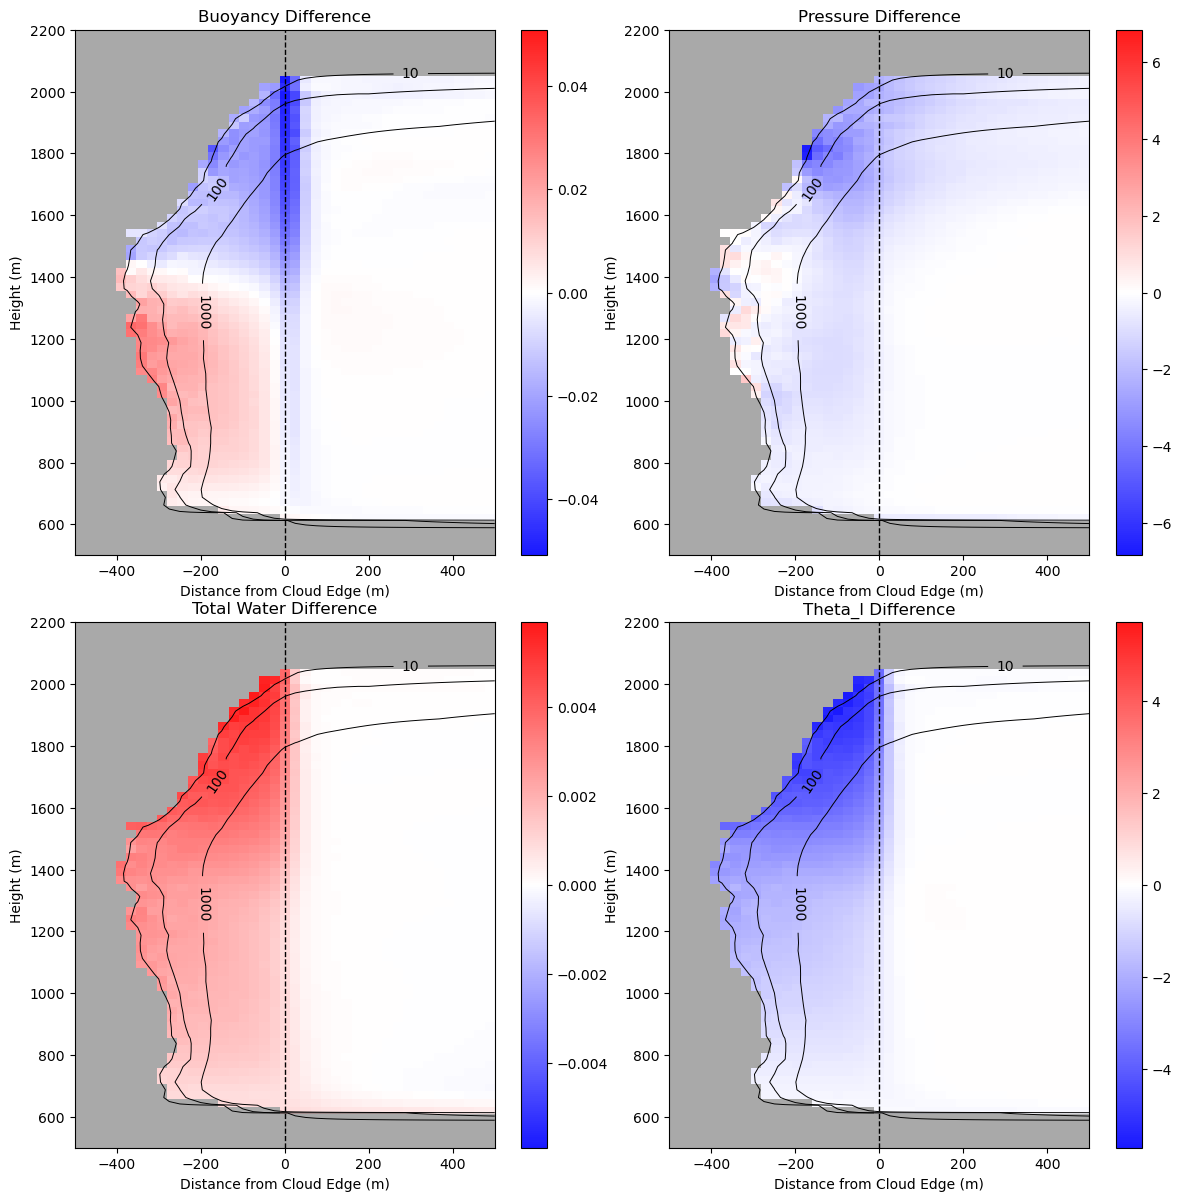

In [6]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt, binary_erosion
from matplotlib.colors import Normalize, ListedColormap, TwoSlopeNorm

# Constants
horizontal_resolution = 25  # Horizontal resolution in meters

# File paths and variable names
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
files = {
    'p': data_dir + 'rico.p.nc',          # Pressure file
    'q': data_dir + 'rico.q.nc',          # Total water content
    't': data_dir + 'rico.t.nc',          # Theta_l (liquid water potential temperature)
    'b': data_dir + 'rico.buoyancy.nc',   # Buoyancy file
    'l': data_dir + 'rico.l.nc',          # Liquid water content (for cloud mask)
}

var_names = {
    'p': 'p',
    'q': 'q',
    't': 't',
    'b': 'buoyancy',
    'l': 'l',
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep].astype(np.float64)
        return data  # Units are assumed to be correct

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_values_vs_distance(data_dict, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge."""
    # data_dict: dictionary of data arrays for variables
    height_levels, ny, nx = next(iter(data_dict.values())).shape
    total_distance = 2 * max_distance + 1
    variables = list(data_dict.keys())
    results = {var: np.full((height_levels, total_distance), np.nan) for var in variables}
    results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

    for z in range(height_levels):
        mask = cloud_mask[z]
        if mask.any():
            dist_out = distance_transform_cdt(~mask, metric='taxicab')
            dist_in = distance_transform_cdt(mask, metric='taxicab')
            distances = np.where(mask, -dist_in + 1, dist_out)

            # Identify cloud edges and set distance to 0
            eroded_mask = binary_erosion(mask)
            cloud_edge = mask & ~eroded_mask
            distances[cloud_edge] = 0

            for d in range(-max_distance, max_distance + 1):
                idx = np.where(distances == d)
                if idx[0].size > 0:
                    pos = d + max_distance
                    for var in variables:
                        results[var][z, pos] = np.mean(data_dict[var][z, idx[0], idx[1]])
                    results['cloud_count'][z, pos] += idx[0].size
    return results

def process_timesteps(timesteps, max_distance):
    all_results = []
    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        # Load data
        b_data = load_data(files['b'], var_names['b'], timestep)
        p_data = load_data(files['p'], var_names['p'], timestep)
        q_data = load_data(files['q'], var_names['q'], timestep)
        t_data = load_data(files['t'], var_names['t'], timestep)
        l_data = load_data(files['l'], var_names['l'], timestep)

        # Create cloud mask
        cloud_mask = l_data > 1e-5  # Threshold for cloud presence

        # Compute domain-wide mean at each vertical level for each variable
        variables = {'b': b_data, 'p': p_data, 'q': q_data, 't': t_data}
        domain_means = {}
        for var, data in variables.items():
            domain_means[var] = np.mean(data, axis=(1, 2))  # Mean over y and x dimensions

        # Compute difference from domain-wide mean at each point
        data_diff = {}
        for var, data in variables.items():
            # Reshape domain mean to broadcast over y and x dimensions
            mean_reshaped = domain_means[var][:, np.newaxis, np.newaxis]
            data_diff[var] = data - mean_reshaped

        # Prepare data_dict for calculate_values_vs_distance
        results = calculate_values_vs_distance(data_diff, cloud_mask, max_distance)
        all_results.append(results)

    mean_results = {}
    for key in all_results[0]:
        stacked_data = np.array([res[key] for res in all_results])
        if key == 'cloud_count':
            mean_results[key] = np.sum(stacked_data, axis=0)
        else:
            mean_results[key] = np.nanmean(stacked_data, axis=0)
    return mean_results

# Parameters
timesteps = list(range(12, 14))
max_distance_meters = 500
max_distance = max_distance_meters // horizontal_resolution
distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Process data
mean_results = process_timesteps(timesteps, max_distance)
zt_values = load_zt(files['t'])  # Load 'zt' from the temperature file

# Plotting
variables = ['b', 'p', 'q', 't']
titles = ['Buoyancy Difference', 'Pressure Difference', 'Total Water Difference', 'Theta_l Difference']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for ax, var, title in zip(axs.flat, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])

    # Colormap settings
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.linspace(0, 1, cmap.N))
    cmap[:, -1] = 0.9  # Transparency
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Normalize using TwoSlopeNorm to center at 0
    vmin_data = np.nanmin(data)
    vmax_data = np.nanmax(data)
    vmax_abs = max(abs(vmin_data), abs(vmax_data))
    norm = TwoSlopeNorm(vcenter=0, vmin=-vmax_abs, vmax=vmax_abs)

    # Plot
    im = ax.imshow(
        data,
        cmap=cmap,
        norm=norm,
        origin='lower',
        aspect='auto',
        extent=[distance_meters[0], distance_meters[-1], zt_values[0], zt_values[-1]]
    )
    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (m)')
    ax.set_ylabel('Height (m)')
    ax.set_ylim(500, 2200)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    fig.colorbar(im, ax=ax)

    # Contours
    cloud_count = mean_results['cloud_count']
    levels = [10, 100, 1000]
    cs = ax.contour(
        distance_meters,
        zt_values,
        cloud_count,
        levels=levels,
        colors='black',
        linewidths=0.7
    )
    ax.clabel(cs, fmt='%d')
#fig.savefig('near_env_domain_difference.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


# Vertically averaged deviation

Processing timestep 12...
Processing timestep 13...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/2803454639.py:98: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/2803454639.py:122: RuntimeWarning: Mean of empty slice
  vertically_averaged_mean[var] = np.nanmean(data, axis=0)  # Shape: (total_distance,)


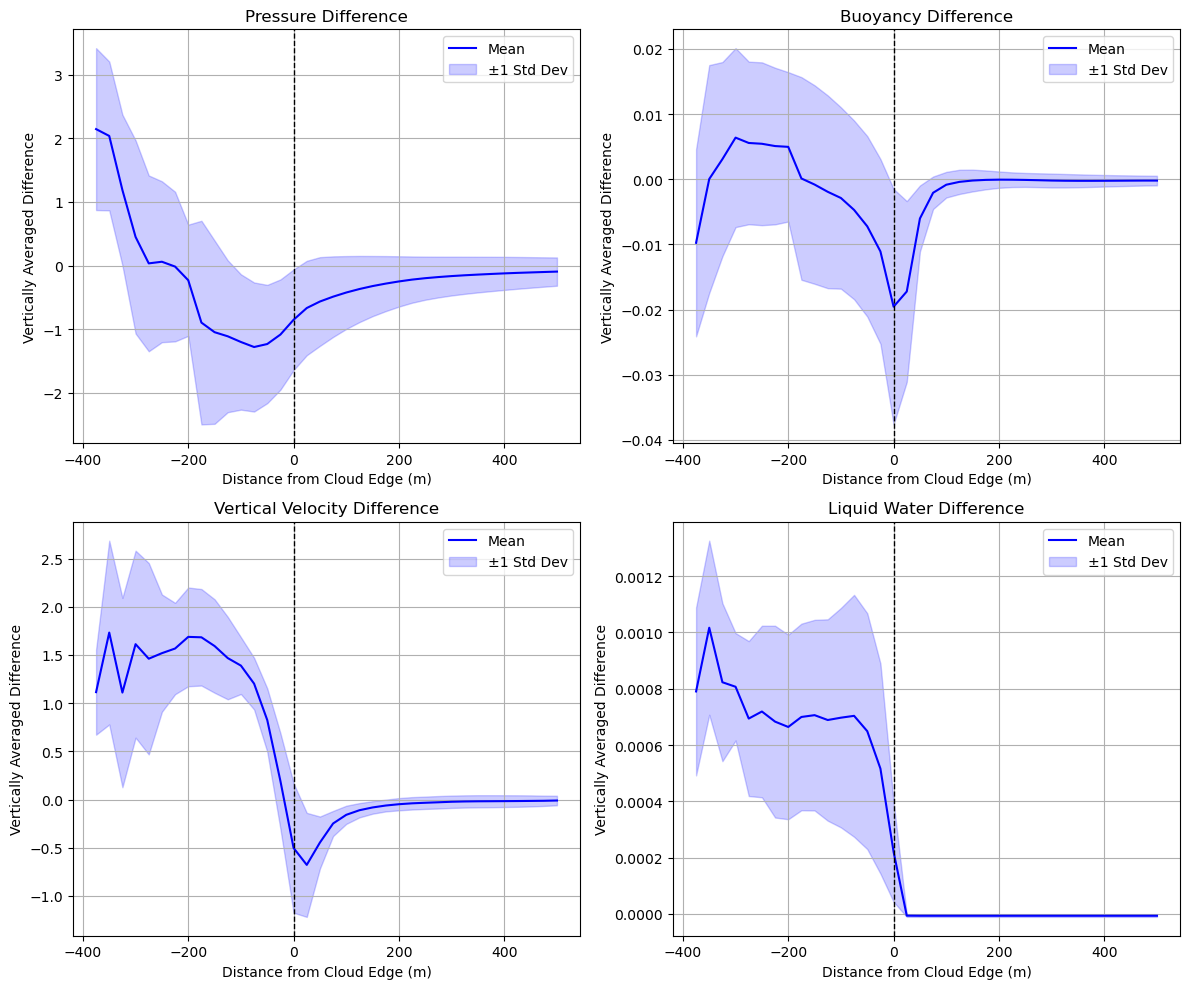

In [8]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import distance_transform_cdt, binary_erosion

# # Constants
# horizontal_resolution = 25  # Horizontal resolution in meters

# # File paths and variable names
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
# files = {
#     'p': data_dir + 'rico.p.nc',          # Pressure file
#     'b': data_dir + 'rico.buoyancy.nc',   # Buoyancy file
#     'w': data_dir + 'rico.w.nc',          # Vertical velocity file
#     'l': data_dir + 'rico.l.nc',          # Liquid water content (for cloud mask and variable)
# }

# var_names = {
#     'p': 'p',
#     'b': 'buoyancy',
#     'w': 'w',
#     'l': 'l',
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep].astype(np.float64)
#         return data  # Units are assumed to be correct

# def calculate_values_vs_distance(data_dict, cloud_mask, max_distance):
#     """Calculate values as a function of distance from cloud edge."""
#     # data_dict: dictionary of data arrays for variables
#     height_levels, ny, nx = next(iter(data_dict.values())).shape
#     total_distance = 2 * max_distance + 1
#     variables = list(data_dict.keys())
#     results = {var: np.full((height_levels, total_distance), np.nan) for var in variables}
#     results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

#     for z in range(height_levels):
#         mask = cloud_mask[z]
#         if mask.any():
#             dist_out = distance_transform_cdt(~mask, metric='taxicab')
#             dist_in = distance_transform_cdt(mask, metric='taxicab')
#             distances = np.where(mask, -dist_in + 1, dist_out)

#             # Identify cloud edges and set distance to 0
#             eroded_mask = binary_erosion(mask)
#             cloud_edge = mask & ~eroded_mask
#             distances[cloud_edge] = 0

#             for d in range(-max_distance, max_distance + 1):
#                 idx = np.where(distances == d)
#                 if idx[0].size > 0:
#                     pos = d + max_distance
#                     for var in variables:
#                         results[var][z, pos] = np.mean(data_dict[var][z, idx[0], idx[1]])
#                     results['cloud_count'][z, pos] += idx[0].size
#     return results

# def process_timesteps(timesteps, max_distance):
#     all_results = []
#     for timestep in timesteps:
#         print(f"Processing timestep {timestep}...")
#         # Load data
#         b_data = load_data(files['b'], var_names['b'], timestep)
#         p_data = load_data(files['p'], var_names['p'], timestep)
#         w_data = load_data(files['w'], var_names['w'], timestep)
#         l_data = load_data(files['l'], var_names['l'], timestep)

#         # Create cloud mask
#         cloud_mask = l_data > 1e-5  # Threshold for cloud presence

#         # Compute domain-wide mean at each vertical level for each variable
#         variables = {'p': p_data, 'b': b_data, 'w': w_data, 'l': l_data}
#         domain_means = {}
#         for var, data in variables.items():
#             domain_means[var] = np.mean(data, axis=(1, 2))  # Mean over y and x dimensions

#         # Compute difference from domain-wide mean at each point
#         data_diff = {}
#         for var, data in variables.items():
#             # Reshape domain mean to broadcast over y and x dimensions
#             mean_reshaped = domain_means[var][:, np.newaxis, np.newaxis]
#             data_diff[var] = data - mean_reshaped

#         # Prepare data_dict for calculate_values_vs_distance
#         results = calculate_values_vs_distance(data_diff, cloud_mask, max_distance)
#         all_results.append(results)

#     # Initialize dictionaries to store mean and standard deviation
#     mean_results = {}
#     std_results = {}
#     for key in all_results[0]:
#         stacked_data = np.array([res[key] for res in all_results])
#         if key == 'cloud_count':
#             mean_results[key] = np.sum(stacked_data, axis=0)
#         else:
#             mean_results[key] = np.nanmean(stacked_data, axis=0)
#             std_results[key] = np.nanstd(stacked_data, axis=0)  # Calculate standard deviation
#     return mean_results, std_results

# # Parameters
# timesteps = list(range(12, 14))
# max_distance_meters = 500
# max_distance = max_distance_meters // horizontal_resolution
# distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# # Process data
# mean_results, std_results = process_timesteps(timesteps, max_distance)

# # Variables to plot
# variables = ['p', 'b', 'w', 'l']
# titles = ['Pressure Difference', 'Buoyancy Difference', 'Vertical Velocity Difference', 'Liquid Water Difference']

# # Calculate vertically averaged mean differences and standard deviations
# vertically_averaged_mean = {}
# vertically_averaged_std = {}
# for var in variables:
#     data = mean_results[var]  # Shape: (height_levels, total_distance)
#     std_data = std_results[var]  # Shape: (height_levels, total_distance)
#     # Compute mean and standard deviation over height levels
#     vertically_averaged_mean[var] = np.nanmean(data, axis=0)  # Shape: (total_distance,)
#     vertically_averaged_std[var] = np.nanstd(data, axis=0)    # Shape: (total_distance,)

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# for ax, var, title in zip(axs.flat, variables, titles):
#     y_mean = vertically_averaged_mean[var]
#     y_std = vertically_averaged_std[var]
#     x_data = distance_meters

#     # Plot mean line
#     ax.plot(x_data, y_mean, color='blue', label='Mean')

#     # Plot shaded area for ±1 standard deviation
#     ax.fill_between(x_data, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Std Dev')

#     ax.set_title(title)
#     ax.set_xlabel('Distance from Cloud Edge (m)')
#     ax.set_ylabel('Vertically Averaged Difference')
#     ax.axvline(0, color='black', linestyle='--', linewidth=1)
#     ax.grid(True)
#     ax.legend()

# plt.tight_layout()
# plt.show()


## Cloud weighted vertically averaged deviation


Processing timestep 3...
Processing timestep 4...
Processing timestep 5...
Processing timestep 6...
Processing timestep 7...
Processing timestep 8...
Processing timestep 9...
Processing timestep 10...
Processing timestep 11...
Processing timestep 12...
Processing timestep 13...
Processing timestep 14...
Processing timestep 15...
Processing timestep 16...
Processing timestep 17...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1696274722.py:98: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1696274722.py:129: RuntimeWarning: invalid value encountered in divide
  weighted_mean = numerator / denominator
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1696274722.py:142: RuntimeWarning: invalid value encountered in divide
  weighted_variance = variance_numerator / variance_denominator


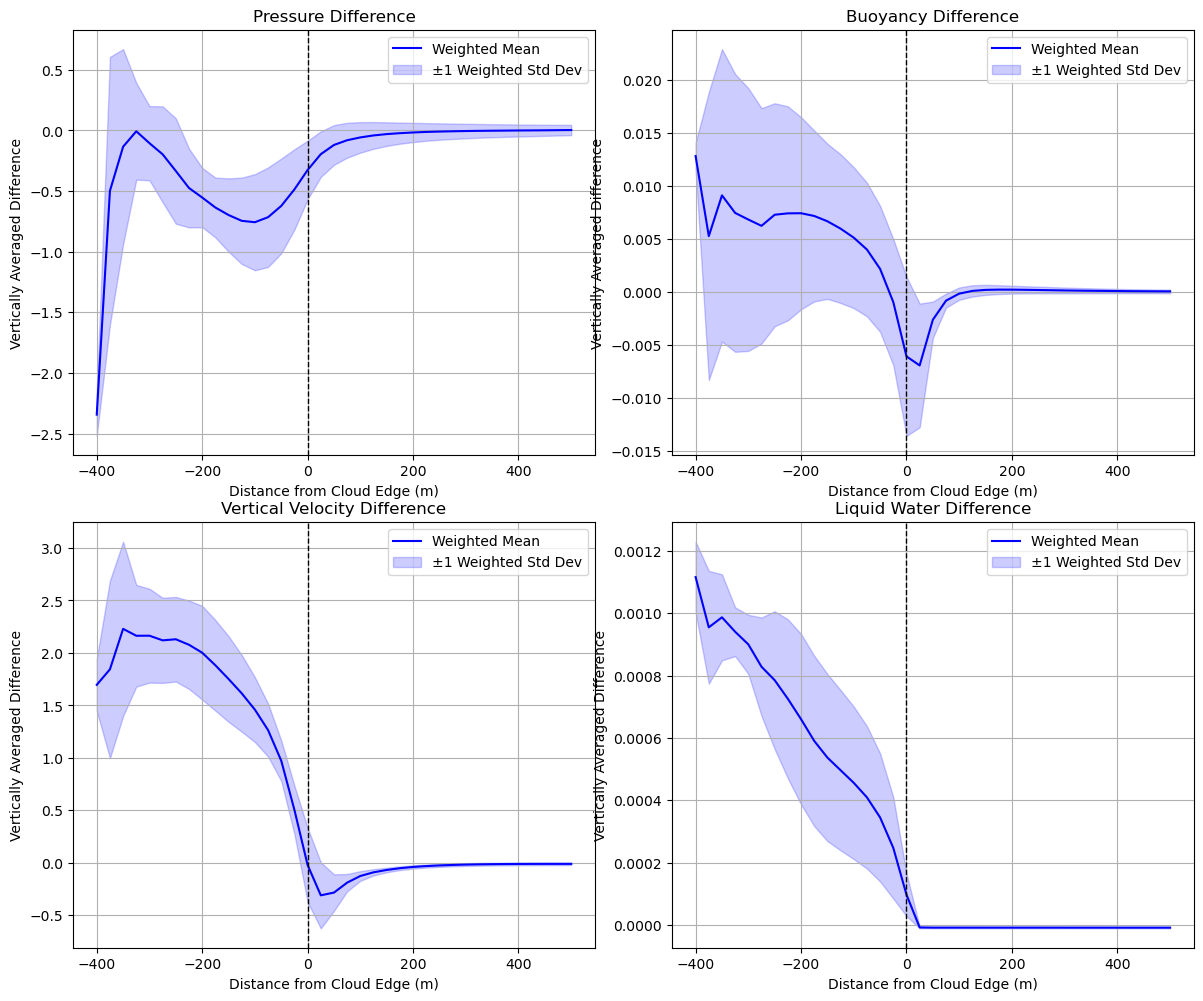

In [10]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import distance_transform_cdt, binary_erosion

# # Constants
# horizontal_resolution = 25  # Horizontal resolution in meters

# # File paths and variable names
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
# files = {
#     'p': data_dir + 'rico.p.nc',          # Pressure file
#     'b': data_dir + 'rico.buoyancy.nc',   # Buoyancy file
#     'w': data_dir + 'rico.w.nc',          # Vertical velocity file
#     'l': data_dir + 'rico.l.nc',          # Liquid water content (for cloud mask and variable)
# }

# var_names = {
#     'p': 'p',
#     'b': 'buoyancy',
#     'w': 'w',
#     'l': 'l',
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep].astype(np.float64)
#         return data  # Units are assumed to be correct

# def calculate_values_vs_distance(data_dict, cloud_mask, max_distance):
#     """Calculate values as a function of distance from cloud edge."""
#     # data_dict: dictionary of data arrays for variables
#     height_levels, ny, nx = next(iter(data_dict.values())).shape
#     total_distance = 2 * max_distance + 1
#     variables = list(data_dict.keys())
#     results = {var: np.full((height_levels, total_distance), np.nan) for var in variables}
#     results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

#     for z in range(height_levels):
#         mask = cloud_mask[z]
#         if mask.any():
#             dist_out = distance_transform_cdt(~mask, metric='taxicab')
#             dist_in = distance_transform_cdt(mask, metric='taxicab')
#             distances = np.where(mask, -dist_in + 1, dist_out)

#             # Identify cloud edges and set distance to 0
#             eroded_mask = binary_erosion(mask)
#             cloud_edge = mask & ~eroded_mask
#             distances[cloud_edge] = 0

#             for d in range(-max_distance, max_distance + 1):
#                 idx = np.where(distances == d)
#                 if idx[0].size > 0:
#                     pos = d + max_distance
#                     for var in variables:
#                         results[var][z, pos] = np.mean(data_dict[var][z, idx[0], idx[1]])
#                     results['cloud_count'][z, pos] += idx[0].size
#     return results

# def process_timesteps(timesteps, max_distance):
#     all_results = []
#     for timestep in timesteps:
#         print(f"Processing timestep {timestep}...")
#         # Load data
#         b_data = load_data(files['b'], var_names['b'], timestep)
#         p_data = load_data(files['p'], var_names['p'], timestep)
#         w_data = load_data(files['w'], var_names['w'], timestep)
#         l_data = load_data(files['l'], var_names['l'], timestep)

#         # Create cloud mask
#         cloud_mask = l_data > 1e-5  # Threshold for cloud presence

#         # Compute domain-wide mean at each vertical level for each variable
#         variables = {'p': p_data, 'b': b_data, 'w': w_data, 'l': l_data}
#         domain_means = {}
#         for var, data in variables.items():
#             domain_means[var] = np.mean(data, axis=(1, 2))  # Mean over y and x dimensions

#         # Compute difference from domain-wide mean at each point
#         data_diff = {}
#         for var, data in variables.items():
#             # Reshape domain mean to broadcast over y and x dimensions
#             mean_reshaped = domain_means[var][:, np.newaxis, np.newaxis]
#             data_diff[var] = data - mean_reshaped

#         # Prepare data_dict for calculate_values_vs_distance
#         results = calculate_values_vs_distance(data_diff, cloud_mask, max_distance)
#         all_results.append(results)

#     # Initialize dictionaries to store mean and standard deviation
#     mean_results = {}
#     std_results = {}
#     for key in all_results[0]:
#         stacked_data = np.array([res[key] for res in all_results])
#         if key == 'cloud_count':
#             mean_results[key] = np.sum(stacked_data, axis=0)
#         else:
#             mean_results[key] = np.nanmean(stacked_data, axis=0)
#             std_results[key] = np.nanstd(stacked_data, axis=0)  # Calculate standard deviation
#     return mean_results, std_results

# # Parameters
# timesteps = list(range(2, 14))
# max_distance_meters = 500
# max_distance = max_distance_meters // horizontal_resolution
# distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# # Process data
# mean_results, std_results = process_timesteps(timesteps, max_distance)

# # Variables to plot
# variables = ['p', 'b', 'w', 'l']
# titles = ['Pressure Difference', 'Buoyancy Difference', 'Vertical Velocity Difference', 'Liquid Water Difference']

# # Calculate vertically averaged weighted mean differences and standard deviations
# vertically_averaged_mean = {}
# vertically_averaged_std = {}

# for var in variables:
#     data = mean_results[var]  # Shape: (height_levels, total_distance)
#     counts = mean_results['cloud_count']  # Shape: (height_levels, total_distance)
#     # Replace zeros with np.nan to avoid division by zero
#     counts_with_nan = counts.astype(np.float64)
#     counts_with_nan[counts_with_nan == 0] = np.nan

#     # Compute weighted mean over height levels
#     numerator = np.nansum(data * counts_with_nan, axis=0)  # Sum over height levels
#     denominator = np.nansum(counts_with_nan, axis=0)  # Sum over height levels
#     weighted_mean = numerator / denominator
#     vertically_averaged_mean[var] = weighted_mean  # Shape: (total_distance,)

#     # Compute weighted standard deviation over height levels
#     # First, compute weighted mean again to be used in std calculation
#     mu = weighted_mean  # Shape: (total_distance,)

#     # Expand mu to shape (height_levels, total_distance) for subtraction
#     mu_expanded = np.broadcast_to(mu, data.shape)

#     # Compute numerator of weighted variance
#     variance_numerator = np.nansum(counts_with_nan * (data - mu_expanded) ** 2, axis=0)
#     variance_denominator = denominator  # Sum of weights
#     weighted_variance = variance_numerator / variance_denominator
#     weighted_std = np.sqrt(weighted_variance)
#     vertically_averaged_std[var] = weighted_std  # Shape: (total_distance,)

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# for ax, var, title in zip(axs.flat, variables, titles):
#     y_mean = vertically_averaged_mean[var]
#     y_std = vertically_averaged_std[var]
#     x_data = distance_meters

#     # Plot mean line
#     ax.plot(x_data, y_mean, color='blue', label='Weighted Mean')

#     # Plot shaded area for ±1 standard deviation
#     ax.fill_between(x_data, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Weighted Std Dev')

#     ax.set_title(title)
#     ax.set_xlabel('Distance from Cloud Edge (m)')
#     ax.set_ylabel('Vertically Averaged Difference')
#     ax.axvline(0, color='black', linestyle='--', linewidth=1)
#     ax.grid(True)
#     ax.legend()

# #fig.savefig('near_env_vertically_averaged_domain_difference.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()



/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/302940521.py:138: RuntimeWarning: Mean of empty slice
  final_mean = np.nanmean(level_bin_means, axis=0)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/302940521.py:186: RuntimeWarning: Mean of empty slice
  mean_across_timesteps[var] = np.nanmean(var_means_per_t, axis=0)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/302940521.py:188: RuntimeWarning: Mean of empty slice
  std_across_timesteps[var] = np.nanmean(var_stds_per_t, axis=0)  # Or another definition


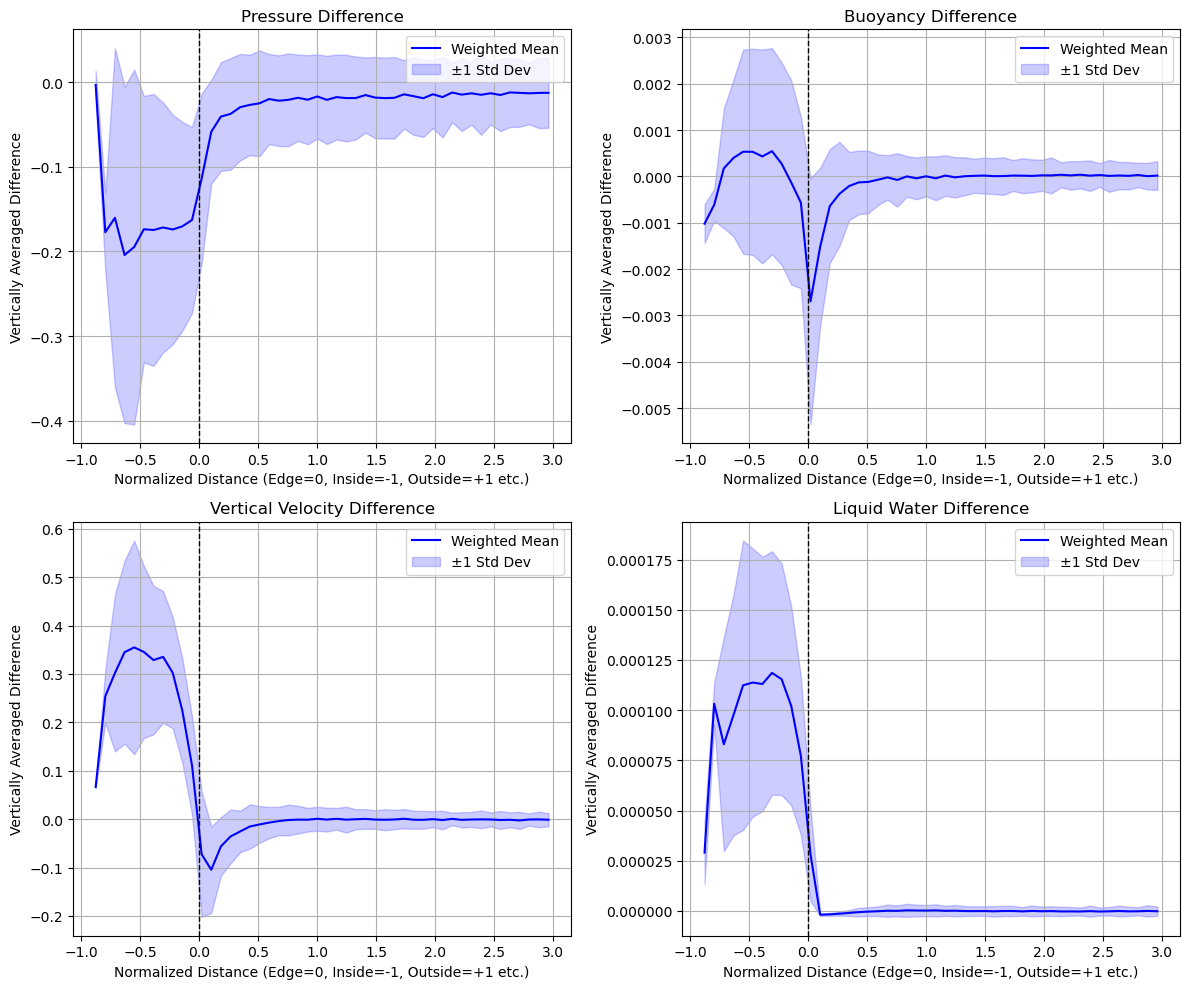

In [15]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import distance_transform_cdt, binary_erosion, label

# # We assume you still have your load_data and process_timesteps structure.

# def find_clouds(cloud_mask_slice):
#     """
#     Identify individual clouds at a given vertical level (2D slice).
#     Returns:
#         labeled_clouds: 2D array of same shape as cloud_mask_slice
#                         with each connected cloud given a unique label (1, 2, 3, ...).
#         num_clouds: The number of identified clouds.
#     """
#     # Consider connectivity=1 or 2 depending on whether diagonal connections count
#     labeled_clouds, num_clouds = label(cloud_mask_slice, structure=np.ones((3,3)))
#     return labeled_clouds, num_clouds

# def compute_perimeter(cloud_mask):
#     """
#     Approximate perimeter by counting the number of boundary pixels.
#     A boundary pixel is any cloud pixel adjacent (in the 4-direction) 
#     to at least one non-cloud pixel.
#     """
#     # Erode the mask and subtract from original to find edges
#     eroded = binary_erosion(cloud_mask, structure=np.ones((3,3)), border_value=1)
#     perimeter_mask = cloud_mask & ~eroded
#     perimeter_count = np.sum(perimeter_mask)  # This counts the number of boundary pixels
#     return perimeter_count

# def calculate_values_normalized_distance(data_dict, cloud_mask, max_normalized_radius=3.0, num_bins=50):
#     """
#     Calculate values as a function of normalized distance from cloud edge.
#     Steps:
#         1. Find individual clouds at each level.
#         2. For each cloud, compute perimeter and radius.
#         3. Compute distances inside and out, normalize by radius.
#         4. Bin data by normalized distance and average.
#     """
#     height_levels, ny, nx = next(iter(data_dict.values())).shape

#     # Create bins in normalized radius units. For example:
#     # from -1.0 (inside) up to +3.0 (outside)
#     distance_bins = np.linspace(-1.0, max_normalized_radius, num_bins)
#     bin_centers = 0.5 * (distance_bins[:-1] + distance_bins[1:])

#     variables = list(data_dict.keys())
#     # We'll accumulate sums and counts for each bin and level
#     # Shape: (height_levels, num_bins-1)
#     value_sums = {var: np.zeros((height_levels, num_bins-1)) for var in variables}
#     value_counts = np.zeros((height_levels, num_bins-1))

#     for z in range(height_levels):
#         mask = cloud_mask[z]
#         if not mask.any():
#             # No clouds at this level
#             continue

#         # Identify individual clouds at this level
#         labeled_clouds, num_clouds = find_clouds(mask)

#         # For each cloud
#         for cloud_id in range(1, num_clouds+1):
#             single_cloud_mask = (labeled_clouds == cloud_id)
#             if not single_cloud_mask.any():
#                 continue

#             # Compute perimeter and radius (in "grid units")
#             perimeter = compute_perimeter(single_cloud_mask)
#             # Radius in grid units:
#             radius = perimeter / (2.0 * np.pi)

#             # Distance transforms:
#             dist_out = distance_transform_cdt(~single_cloud_mask, metric='taxicab')
#             dist_in = distance_transform_cdt(single_cloud_mask, metric='taxicab')
#             distances = np.where(single_cloud_mask, -dist_in + 1, dist_out)

#             # Identify cloud edge
#             eroded_mask = binary_erosion(single_cloud_mask)
#             cloud_edge = single_cloud_mask & ~eroded_mask
#             distances[cloud_edge] = 0

#             # Normalize distances by radius
#             # distance_norm = distance_in_grid_points / radius
#             distance_norm = distances / radius

#             # Get indices of all cloud and nearby points you want to consider
#             # If you want to limit how far you go:
#             # Keep points within -1.0 and max_normalized_radius
#             valid_mask = (distance_norm >= -1.0) & (distance_norm <= max_normalized_radius)
#             dz_idx, dy_idx = np.where(valid_mask)

#             if dz_idx.size == 0:
#                 continue

#             # Extract data values for those points
#             for var in variables:
#                 var_data = data_dict[var][z, :, :]  # shape (ny, nx)
#                 var_values = var_data[dy_idx, dz_idx]  # careful with indexing: distances is (ny, nx)
#                 # Actually, we need to ensure consistent indexing:
#                 # distance_norm, single_cloud_mask are shaped (ny, nx)
#                 # and dz_idx, dy_idx are from np.where(valid_mask).
#                 # This means dy_idx, dz_idx correspond to (y, x) coords.
#                 # Just keep consistent: var_data[y, x]
#                 # Make sure to use the correct order of indexing (dy_idx is y, dz_idx is x):
#                 var_values = var_data[dy_idx, dz_idx]

#                 # Bin by normalized distance
#                 dist_vals = distance_norm[dy_idx, dz_idx]
#                 bin_indices = np.digitize(dist_vals, distance_bins) - 1
#                 # Accumulate sums
#                 for b_i in range(num_bins-1):
#                     mask_bin = (bin_indices == b_i)
#                     if mask_bin.any():
#                         value_sums[var][z, b_i] += np.nanmean(var_values[mask_bin])
#                 # Count how many points fall into each bin
#                 for b_i in range(num_bins-1):
#                     mask_bin = (bin_indices == b_i)
#                     if mask_bin.any():
#                         # Counting how many points contributed to this mean
#                         # If we want a weighted average per bin across all clouds, we need counts:
#                         value_counts[z, b_i] += 1

#     # Compute averages
#     # value_sums[var][z, b_i] currently holds summed means per cloud.
#     # value_counts[z, b_i] holds how many clouds contributed.
#     # Final mean across all clouds at that level and bin:
#     final_means = {}
#     final_stds = {}
#     for var in variables:
#         with np.errstate(invalid='ignore'):
#             level_bin_means = value_sums[var] / value_counts
#         # Now average across height levels if desired
#         # For simplicity, let's just do a vertical mean (ignoring height weighting)
#         # If you want a vertical weighting, adjust accordingly.
#         with np.errstate(invalid='ignore'):
#             final_mean = np.nanmean(level_bin_means, axis=0)

#         # Compute std across height levels
#         # Recompute variance: first gather all level means to then compute std
#         # This is a simplistic approach. If you want a more rigorous approach (like weighted),
#         # you'd have to store individual cloud data or do this differently.
#         final_std = np.nanstd(level_bin_means, axis=0)

#         final_means[var] = final_mean
#         final_stds[var] = final_std

#     return bin_centers, final_means, final_stds


# # In your main code, you would now call a modified process like this:
# timesteps = list(range(13,14))
# all_final_means = []
# all_final_stds = []

# for timestep in timesteps:
#     # Load data as before
#     b_data = load_data(files['b'], var_names['b'], timestep)
#     p_data = load_data(files['p'], var_names['p'], timestep)
#     w_data = load_data(files['w'], var_names['w'], timestep)
#     l_data = load_data(files['l'], var_names['l'], timestep)

#     # Create cloud mask
#     cloud_mask = l_data > 1e-5

#     variables = {'p': p_data, 'b': b_data, 'w': w_data, 'l': l_data}
#     # Compute domain means and differences as before
#     domain_means = {var: np.mean(d, axis=(1,2))[:, np.newaxis, np.newaxis] for var, d in variables.items()}
#     data_diff = {var: variables[var] - domain_means[var] for var in variables}

#     bin_centers, final_means, final_stds = calculate_values_normalized_distance(data_diff, cloud_mask, max_normalized_radius=3.0, num_bins=50)
#     all_final_means.append(final_means)
#     all_final_stds.append(final_stds)

# # After collecting results from all timesteps, average them again if needed
# # For simplicity, let's just do a mean over timesteps:
# variables = ['p', 'b', 'w', 'l']
# mean_across_timesteps = {}
# std_across_timesteps = {}
# for var in variables:
#     # Stack results from each timestep
#     var_means_per_t = np.array([res[var] for res in all_final_means]) # shape (num_timesteps, num_bins-1)
#     var_stds_per_t = np.array([res[var] for res in all_final_stds]) # shape (num_timesteps, num_bins-1)

#     mean_across_timesteps[var] = np.nanmean(var_means_per_t, axis=0)
#     # For std across timesteps, one could do a similar approach
#     std_across_timesteps[var] = np.nanmean(var_stds_per_t, axis=0)  # Or another definition

# # Plot results
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# titles = ['Pressure Difference', 'Buoyancy', 'Vertical Velocity Difference', 'Liquid Water Difference']

# for ax, var, title in zip(axs.flat, variables, titles):
#     y_mean = mean_across_timesteps[var]
#     y_std = std_across_timesteps[var]
#     x_data = bin_centers

#     ax.plot(x_data, y_mean, color='blue', label='Weighted Mean')
#     ax.fill_between(x_data, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Std Dev')

#     ax.set_title(title)
#     ax.set_xlabel('Normalized Distance')
#     ax.set_ylabel('Vertically Averaged Difference')
#     ax.axvline(0, color='black', linestyle='--', linewidth=1)
#     ax.grid(True)
#     ax.legend()
# #fig.savefig('near_env_vertically_averaged_domain_difference_normalised_dist.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()


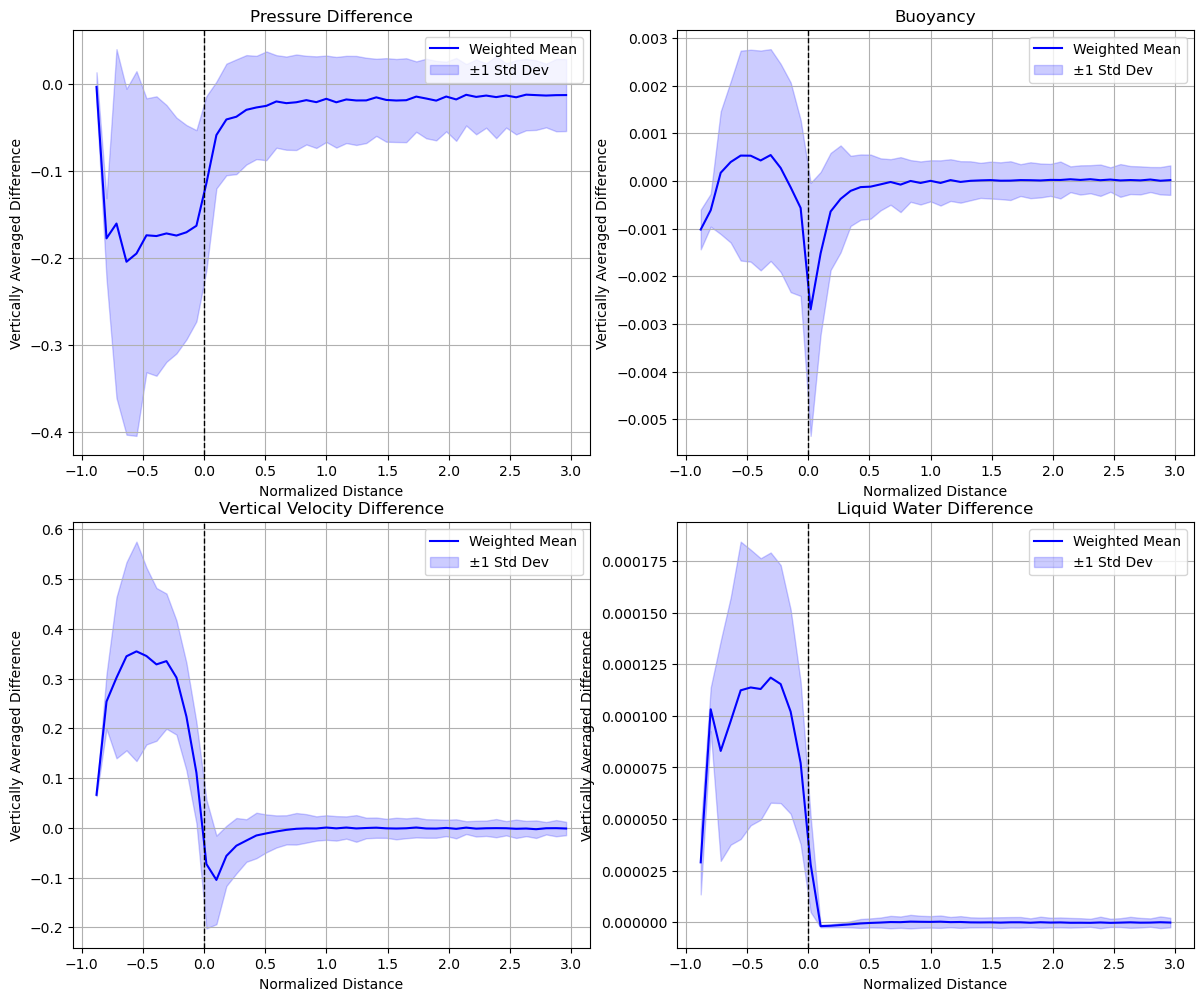

# Binning by vertical velocity

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1890747377.py:81: RuntimeWarning: Mean of empty slice
  liquid_water_mean = np.nanmean(liquid_water_means_per_timestep, axis=0)


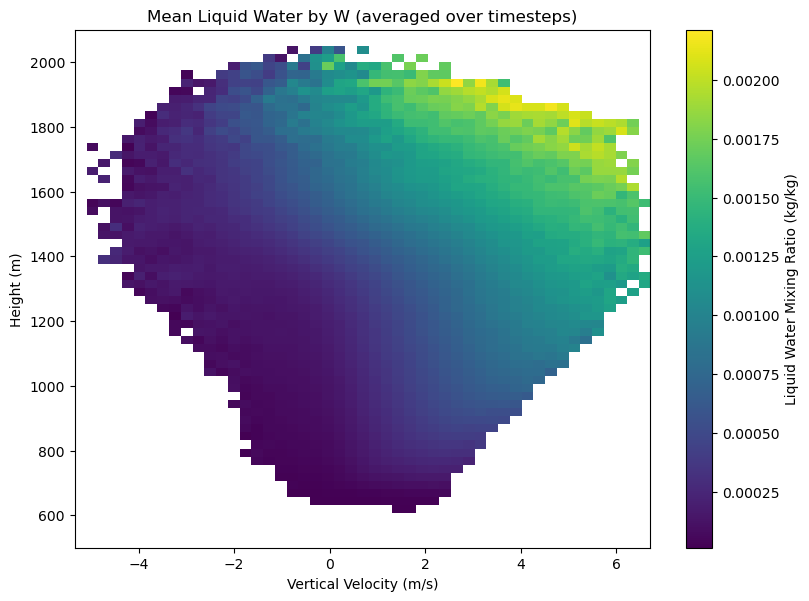

In [66]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt

# # Parameters and setup
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     't': data_dir + 'rico.t.nc'   # For zt
# }

# # Define variable names
# var_names = {
#     'w': 'w',
#     'l': 'l',
#     't': 't'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep].astype(np.float64)
#     return data

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# timesteps = range(13, 18)  # Example timesteps
# zt_values = load_zt(files['t'])
# height_levels = zt_values.size

# # Load data for all timesteps
# all_l_data = []
# all_w_data = []
# for timestep in timesteps:
#     w_data = load_data(files['w'], var_names['w'], timestep)
#     l_data = load_data(files['l'], var_names['l'], timestep)
#     all_w_data.append(w_data)
#     all_l_data.append(l_data)
# all_w_data = np.array(all_w_data)  # shape: (time, z, y, x)
# all_l_data = np.array(all_l_data)  # shape: (time, z, y, x)

# # Determine w-bin edges from the entire dataset
# w_min = np.nanmin(all_w_data)
# w_max = np.nanmax(all_w_data)
# w_bins = np.linspace(w_min, w_max, 50)  # 50 bins from w_min to w_max
# w_bin_centers = 0.5*(w_bins[:-1] + w_bins[1:])

# # Prepare array to hold results for each timestep
# # We'll compute mean l for each (time, z, w_bin)
# liquid_water_means_per_timestep = np.full((len(timesteps), height_levels, len(w_bin_centers)), np.nan)

# # Loop over timesteps
# for t_i, timestep in enumerate(timesteps):
#     w_data_t = all_w_data[t_i, ...]  # (z, y, x)
#     l_data_t = all_l_data[t_i, ...]  # (z, y, x)
    
#     # Create a cloud mask for this timestep
#     cloud_mask = l_data_t > 1e-5

#     # For each height, compute mean l per w_bin
#     for z in range(height_levels):
#         # Select only cloud points at this height
#         w_layer = w_data_t[z,:,:][cloud_mask[z,:,:]]
#         l_layer = l_data_t[z,:,:][cloud_mask[z,:,:]]

#         if w_layer.size == 0:
#             continue  # No clouds at this level

#         # Digitize w values into bins
#         w_indices = np.digitize(w_layer, w_bins) - 1  # convert to 0-based index

#         # Compute mean l per w_bin
#         for i in range(len(w_bin_centers)):
#             bin_mask = (w_indices == i)
#             if np.any(bin_mask):
#                 liquid_water_means_per_timestep[t_i, z, i] = np.mean(l_layer[bin_mask])

# # After processing all timesteps, average over the time dimension
# liquid_water_mean = np.nanmean(liquid_water_means_per_timestep, axis=0)

# # Now plot liquid_water_mean as height vs w_bin_centers
# fig, ax = plt.subplots(figsize=(8,6))

# # Mask invalid
# data = np.ma.masked_invalid(liquid_water_mean)

# # Plot
# im = ax.imshow(
#     data,
#     origin='lower',
#     aspect='auto',
#     extent=[w_bin_centers[0], w_bin_centers[-1], zt_values[0], zt_values[-1]]
# )

# ax.set_ylim([500, 2100])
# ax.set_xlabel('Vertical Velocity (m/s)')
# ax.set_ylabel('Height (m)')
# ax.set_title('Mean Liquid Water by W (averaged over timesteps)')
# fig.colorbar(im, ax=ax, label='Liquid Water Mixing Ratio (kg/kg)')

# # Remove unused legend call if not needed
# # ax.legend()
# #fig.savefig('vertical_liq_water_by_w.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()


# Cloud distance binned by vertical velocity

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/943721192.py:146: RuntimeWarning: Mean of empty slice
  distance_mean = np.nanmean(distance_means_per_timestep, axis=0)


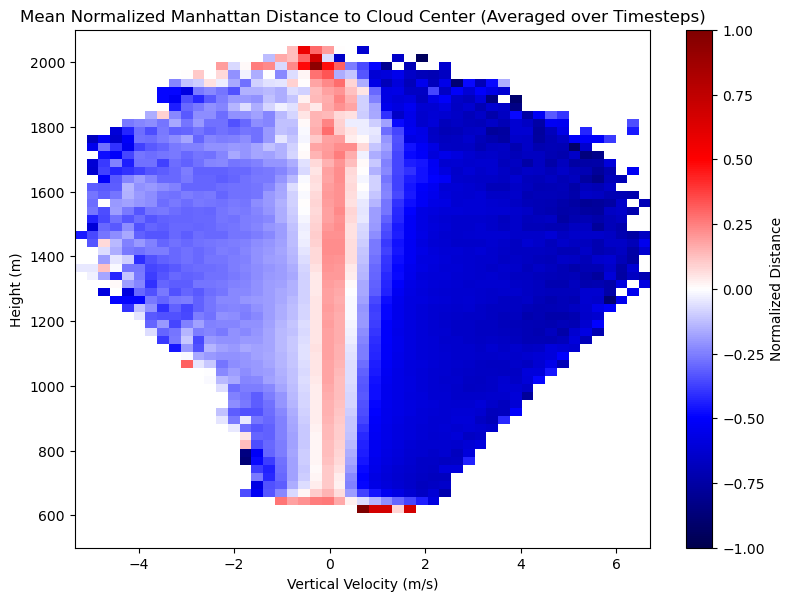

In [68]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import label

# # Parameters and setup
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     't': data_dir + 'rico.t.nc'   # For zt
# }

# # Variable names
# var_names = {
#     'w': 'w',
#     'l': 'l',
#     't': 't'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep].astype(np.float64)
#     return data

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# timesteps = range(13, 15)  # Example timesteps
# zt_values = load_zt(files['t'])
# height_levels = zt_values.size

# # Load all data first
# all_w_data = []
# all_l_data = []
# for timestep in timesteps:
#     w_data = load_data(files['w'], var_names['w'], timestep)  # (z, y, x)
#     l_data = load_data(files['l'], var_names['l'], timestep)  # (z, y, x)
#     all_w_data.append(w_data)
#     all_l_data.append(l_data)
    
# all_w_data = np.array(all_w_data)  # shape: (time, z, y, x)
# all_l_data = np.array(all_l_data)  # shape: (time, z, y, x)

# threshold = 1e-5
# time_len, z_len, y_len, x_len = all_l_data.shape

# Y, X = np.meshgrid(np.arange(y_len), np.arange(x_len), indexing='ij')

# # We want to find min and max w over all times to define bins
# w_min = np.nanmin(all_w_data)
# w_max = np.nanmax(all_w_data)
# w_bins = np.linspace(w_min, w_max, 50)  # 50 bins
# w_bin_centers = 0.5*(w_bins[:-1] + w_bins[1:])

# # We'll store results for each timestep
# distance_means_per_timestep = np.full((time_len, height_levels, len(w_bin_centers)), np.nan)

# for t_i, timestep in enumerate(timesteps):
#     l_data_t = all_l_data[t_i]  # (z, y, x)
#     w_data_t = all_w_data[t_i]  # (z, y, x)

#     # We'll compute normalized_distance_field for this timestep
#     normalized_distance_field_t = np.full((z_len, y_len, x_len), np.nan)

#     for z in range(z_len):
#         # Identify clouds at this level for this timestep
#         cloud_mask_level = (l_data_t[z,:,:] > threshold)
        
#         # Label connected components (clouds) at this level
#         structure_2d = np.ones((3,3))  # 8-connectivity in 2D
#         labeled_clouds, num_clouds = label(cloud_mask_level, structure=structure_2d)

#         if num_clouds == 0:
#             continue

#         for cloud_id in range(1, num_clouds+1):
#             cloud_points = (labeled_clouds == cloud_id)
#             if not np.any(cloud_points):
#                 continue

#             y_coords = Y[cloud_points]
#             x_coords = X[cloud_points]

#             # Compute cloud center (mean x,y)
#             x_center = np.mean(x_coords)
#             y_center = np.mean(y_coords)

#             # Compute Manhattan distances for cloud points
#             cloud_distances = np.abs(x_coords - x_center) + np.abs(y_coords - y_center)

#             # Radius of the cloud (max Manhattan distance)
#             cloud_radius = np.max(cloud_distances)
#             if cloud_radius == 0:
#                 # Single-point cloud
#                 y0, x0 = int(y_center), int(x_center)
#                 # At the center, distance is -1
#                 normalized_distance_field_t[z, y0, x0] = -1.0
#                 continue

#             # Define max extension beyond the cloud radius if desired
#             max_ext_dist = cloud_radius

#             # Find bounding box for extended region
#             y_min = int(max(y_center - max_ext_dist, 0))
#             y_max = int(min(y_center + max_ext_dist, y_len-1))
#             x_min = int(max(x_center - max_ext_dist, 0))
#             x_max = int(min(x_center + max_ext_dist, x_len-1))

#             # Create a grid of coordinates in the extended region
#             Y_sub, X_sub = np.meshgrid(np.arange(y_min, y_max+1), np.arange(x_min, x_max+1), indexing='ij')
            
#             # Compute Manhattan distances in this subregion
#             sub_distances = np.abs(X_sub - x_center) + np.abs(Y_sub - y_center)
#             # Normalize by the cloud radius: distance/ radius - 1
#             sub_norm_distances = sub_distances / cloud_radius - 1

#             dist_slice = normalized_distance_field_t[z, y_min:y_max+1, x_min:x_max+1]
#             mask_update = np.isnan(dist_slice) | (sub_norm_distances < dist_slice)
#             dist_slice[mask_update] = sub_norm_distances[mask_update]
#             normalized_distance_field_t[z, y_min:y_max+1, x_min:x_max+1] = dist_slice

#     # Now we have normalized_distance_field_t for this timestep
#     # Next, we bin by w for this timestep separately.

#     # For each height level, we flatten (y,x) and consider all valid points
#     for z in range(height_levels):
#         dist_z = normalized_distance_field_t[z,:,:].ravel()
#         w_z = w_data_t[z,:,:].ravel()

#         valid_mask_z = ~np.isnan(dist_z)
#         dist_z = dist_z[valid_mask_z]
#         w_z = w_z[valid_mask_z]

#         if dist_z.size == 0:
#             continue

#         w_indices = np.digitize(w_z, w_bins) - 1
#         for i in range(len(w_bin_centers)):
#             bin_mask = (w_indices == i)
#             if np.any(bin_mask):
#                 distance_means_per_timestep[t_i, z, i] = np.mean(dist_z[bin_mask])

# # After processing all timesteps, average over time
# distance_mean = np.nanmean(distance_means_per_timestep, axis=0)

# # Plotting the results
# fig, ax = plt.subplots(figsize=(8,6))
# data = np.ma.masked_invalid(distance_mean)

# im = ax.imshow(
#     data,
#     origin='lower',
#     aspect='auto',
#     extent=[w_bin_centers[0], w_bin_centers[-1], zt_values[0], zt_values[-1]],
#     cmap='seismic',
#     vmin=-1, vmax=1
# )

# ax.set_xlabel('Vertical Velocity (m/s)')
# ax.set_ylabel('Height (m)')
# ax.set_ylim([500, 2100])
# ax.set_title('Mean Normalized Manhattan Distance to Cloud Center (Averaged over Timesteps)')
# cbar = fig.colorbar(im, ax=ax, label='Normalized Distance')


# #fig.savefig('distance_by_w.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()


# Same but in-cloud only

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/2737021419.py:133: RuntimeWarning: Mean of empty slice
  distance_mean = np.nanmean(distance_means_per_timestep, axis=0)


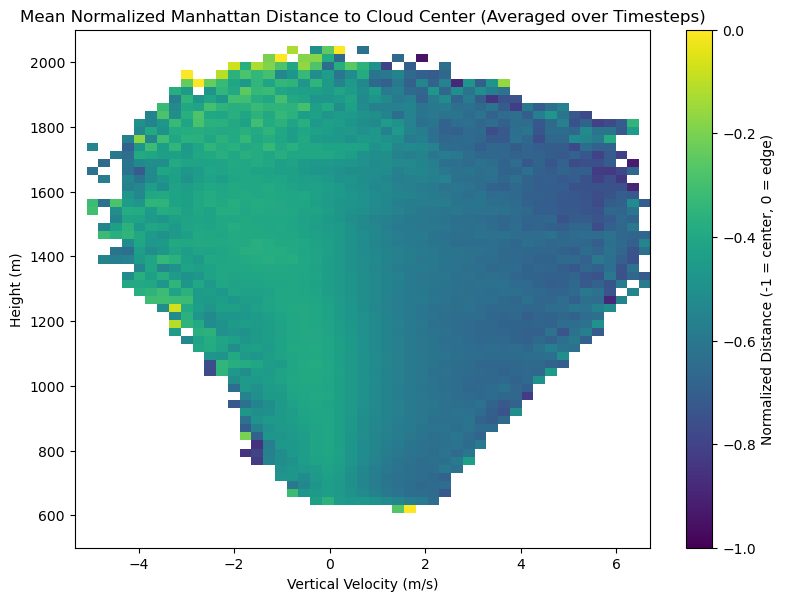

In [69]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import label

# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     't': data_dir + 'rico.t.nc'
# }

# var_names = {
#     'w': 'w',
#     'l': 'l',
#     't': 't'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep].astype(np.float64)
#     return data

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# timesteps = range(13, 18)
# zt_values = load_zt(files['t'])
# height_levels = zt_values.size

# all_l_data = []
# all_w_data = []

# for timestep in timesteps:
#     w_data = load_data(files['w'], var_names['w'], timestep)
#     l_data = load_data(files['l'], var_names['l'], timestep)
#     all_w_data.append(w_data)
#     all_l_data.append(l_data)

# all_w_data = np.array(all_w_data)  
# all_l_data = np.array(all_l_data)

# threshold = 1e-5
# time_len, z_size, y_size, x_size = all_l_data.shape
# Y, X = np.meshgrid(np.arange(y_size), np.arange(x_size), indexing='ij')

# # Determine w-range from all_w_data to include all velocities
# w_min = np.nanmin(all_w_data)
# w_max = np.nanmax(all_w_data)
# w_bins = np.linspace(w_min, w_max, 50)  # 50 bins
# w_bin_centers = 0.5*(w_bins[:-1] + w_bins[1:])

# # We'll store results for each timestep, then average at the end
# distance_means_per_timestep = np.full((time_len, height_levels, len(w_bin_centers)), np.nan)

# for t_i, timestep in enumerate(timesteps):
#     l_data_t = all_l_data[t_i]  # (z, y, x)
#     w_data_t = all_w_data[t_i]  # (z, y, x)

#     # Initialize normalized distance field for this timestep
#     normalized_distance_field_t = np.full((z_size, y_size, x_size), np.nan)

#     # Identify clouds at each level and compute normalized distances for this timestep
#     for z in range(z_size):
#         # Cloud mask at this level for this timestep
#         cloud_mask_level = (l_data_t[z,:,:] > threshold)

#         # Label connected components at this level (2D)
#         structure_2d = np.ones((3,3))  # 8-connectivity in 2D
#         labeled_clouds, num_clouds = label(cloud_mask_level, structure=structure_2d)

#         if num_clouds == 0:
#             continue

#         # For each 2D cloud at this level
#         for cloud_id in range(1, num_clouds+1):
#             cloud_points = (labeled_clouds == cloud_id)
#             if not np.any(cloud_points):
#                 continue

#             y_coords = Y[cloud_points]
#             x_coords = X[cloud_points]

#             # Compute cloud center
#             x_center = np.mean(x_coords)
#             y_center = np.mean(y_coords)

#             # Manhattan distances within cloud
#             cloud_distances = np.abs(x_coords - x_center) + np.abs(y_coords - y_center)

#             # Cloud radius
#             cloud_radius = np.max(cloud_distances)
#             if cloud_radius == 0:
#                 # Single-point cloud
#                 y0, x0 = int(y_center), int(x_center)
#                 curr_val = normalized_distance_field_t[z, y0, x0]
#                 if np.isnan(curr_val):
#                     normalized_distance_field_t[z, y0, x0] = -1.0
#                 else:
#                     normalized_distance_field_t[z, y0, x0] = min(curr_val, -1.0)
#                 continue

#             # Normalize distances: -1 at center, 0 at cloud edge
#             sub_norm_distances = cloud_distances / cloud_radius - 1

#             # Update normalized_distance_field for cloud points
#             for yy, xx, ndist in zip(y_coords, x_coords, sub_norm_distances):
#                 curr_val = normalized_distance_field_t[z, yy, xx]
#                 if np.isnan(curr_val) or ndist < curr_val:
#                     normalized_distance_field_t[z, yy, xx] = ndist

#     # Now, bin by w for this timestep
#     # Only consider inside cloud points where distance ≤ 0
#     for z in range(height_levels):
#         dist_z = normalized_distance_field_t[z,:,:].ravel()
#         w_z = w_data_t[z,:,:].ravel()

#         inside_mask = ~np.isnan(dist_z) & (dist_z <= 0)
#         dist_z = dist_z[inside_mask]
#         w_z = w_z[inside_mask]

#         if dist_z.size == 0:
#             continue

#         w_indices = np.digitize(w_z, w_bins) - 1
#         for i in range(len(w_bin_centers)):
#             bin_mask = (w_indices == i)
#             if np.any(bin_mask):
#                 distance_means_per_timestep[t_i, z, i] = np.mean(dist_z[bin_mask])

# # After processing all timesteps, average over time
# distance_mean = np.nanmean(distance_means_per_timestep, axis=0)

# # Plotting the results, focusing on inside of the cloud only (distance ≤ 0)
# fig, ax = plt.subplots(figsize=(8,6))
# data = np.ma.masked_invalid(distance_mean)

# # The range is from -1 (center) to 0 (edge)
# im = ax.imshow(
#     data,
#     origin='lower',
#     aspect='auto',
#     extent=[w_bin_centers[0], w_bin_centers[-1], zt_values[0], zt_values[-1]],
#     cmap='viridis',
#     vmin=-1,
#     vmax=0
# )

# ax.set_xlabel('Vertical Velocity (m/s)')
# ax.set_ylabel('Height (m)')
# ax.set_ylim([500, 2100])
# ax.set_title('Mean Normalized Manhattan Distance to Cloud Center (Averaged over Timesteps)')
# cbar = fig.colorbar(im, ax=ax, label='Normalized Distance (-1 = center, 0 = edge)')

# #fig.savefig('incloud_distance_by_w.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()
